In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime

2024-05-12 13:55:19.940184: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 13:55:19.985215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 13:55:19.985242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 13:55:19.986347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 13:55:19.993798: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed=360
num_components=4
learning_rate = 0.05
epochs=200
outdir = '/cluster/home/kheuto01/testdir'
penalty = 5000
threshold = 0.55
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500
perturbed_sigma=0.1
num_score_func_samples=5
batch_size=50

In [3]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed, batch_size=batch_size)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)
input_shape = (H,S)

bpr_K = get_perturbed_bpr_func(K, sigma=perturbed_sigma)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


2024-05-12 13:55:29.942357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-12 13:55:29.942398: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-05-12 13:55:29.942407: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-05-12 13:55:29.942499: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-12 13:55:29.942539: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-12 13:55:29.942544: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


In [4]:
model, mix_weights  = mixture_poissons(location_specific_linear, input_shape, num_components=num_components)

In [5]:
lossses = training_loop_score_function_trick(model, optimizer, epochs, train_dataset, val_dataset,
                                       cross_ratio_decision, bpr_K,
                                       objective_includes_likelihood=True,
                                       objective_includes_bpr=True,
                                       bpr_threshold=threshold,
                                       penalty=penalty,
                                       num_score_func_samples=num_score_func_samples,
                                       verbose=True)

Epoch 0
Loss: 641.2909545898438
NLL: -132.037353515625
BPR: 0.49988770484924316
Epoch 1
Loss: 602.366455078125
NLL: -130.86505126953125
BPR: 0.5108512043952942
Epoch 2
Loss: 595.0980224609375
NLL: -129.4993438720703
BPR: 0.5153710246086121
Epoch 3
Loss: 568.1414184570312
NLL: -128.6855010986328
BPR: 0.5197961926460266
Epoch 4
Loss: 547.00048828125
NLL: -130.8159637451172
BPR: 0.5305407643318176
Epoch 5
Loss: 556.2125854492188
NLL: -141.51846313476562
BPR: 0.5235878825187683
Epoch 6
Loss: 563.0090942382812
NLL: -170.57009887695312
BPR: 0.536469578742981
Epoch 7


In [5]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
#tf.summary.trace_on(graph=True, profiler=True)

In [8]:
#@tf.function
def do_it_all(prob_params_BSK, mixture_weights_KS, y_BS):
    # my fault that model returns KS instead of SK
    mixture_weights_SK = tf.transpose(mixture_weights_KS, perm=[1,0])

    #  could create a custom model class that returns 
    # the appropriate tfp.dist given outputs
    mix = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(probs=mixture_weights_SK),#+1e-13),
        components_distribution = tfp.distributions.Poisson(rate=prob_params_BSK+1e-13))

    # add constant to avoid log 0
    sample_y_MBS = mix.sample(num_score_func_samples)#+1e-13

    sample_log_probs_MBS = mix.log_prob(sample_y_MBS)
    sample_decisions_MBS = cross_ratio_decision(sample_y_MBS)
    expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
    bpr_B = bpr_K(y_BS, expected_decisions_BS)
    observed_log_prob_BS = mix.log_prob(y_BS)


    loss_B = -tf.reduce_sum(observed_log_prob_BS, axis=-1)

    violate_threshold_flag_B = tf.cast(tf.greater(threshold,
                                                bpr_B),
                                        tf.float32)
    loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)

    return loss_B, sample_log_probs_MBS, sample_decisions_MBS, expected_decisions_BS, observed_log_prob_BS, bpr_B

In [13]:
bpr_K

functools.partial(<function positive_bpr_K_uncurried at 0x2adb76dbe200>, K=4, perturbed_top_K_func=<function perturbed.<locals>.wrapper at 0x2adb76ff2200>)

In [9]:
#check numerics
tf.debugging.disable_check_numerics()

losses = {}
losses['train'] = {}
losses['val'] ={}
losses['train']['loss']=[]
losses['train']['nll']=[]
losses['train']['bpr']=[]
losses['val']['loss']=[]
losses['val']['nll']=[]
losses['val']['bpr']=[]
verbose=True
for epoch in range(100):
        #tf.summary.trace_on(graph=True, profiler=True)
        if verbose:
            print(f'Epoch {epoch}')
        else:
            if epoch % 10 == 0:
                print(f'Epoch {epoch}')

        batch_losses = {'train': {'loss': [], 'nll': [], 'bpr': []}}

        for step, (x_BHS, y_BS) in enumerate(train_dataset):
            #print(step)
            
            with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
                prob_params_BSK, mixture_weights_KS = model(x_BHS, training=True)
                loss_B, sample_log_probs_MBS, sample_decisions_MBS, expected_decisions_BS, observed_log_prob_BS, bpr_B = do_it_all(prob_params_BSK, mixture_weights_KS, y_BS)
                '''
                # my fault that model returns KS instead of SK
                mixture_weights_SK = tf.transpose(mixture_weights_KS, perm=[1,0])

                #  could create a custom model class that returns 
                # the appropriate tfp.dist given outputs
                mix = tfp.distributions.MixtureSameFamily(
                    mixture_distribution=tfp.distributions.Categorical(probs=mixture_weights_SK),#+1e-13),
                    components_distribution = tfp.distributions.Poisson(rate=prob_params_BSK+1e-13))

                # add constant to avoid log 0
                sample_y_MBS = mix.sample(num_score_func_samples)#+1e-13

                sample_log_probs_MBS = mix.log_prob(sample_y_MBS)
                sample_decisions_MBS = cross_ratio_decision(sample_y_MBS)
                expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
                bpr_B = bpr_K(y_BS, expected_decisions_BS)
                observed_log_prob_BS = mix.log_prob(y_BS)

                loss_B = tf.zeros_like(bpr_B)

                if True:
                    loss_B -= tf.reduce_sum(observed_log_prob_BS, axis=-1)
                if True:
                    violate_threshold_flag_B = tf.cast(tf.greater(threshold,
                                                                bpr_B),
                                                        tf.float32)
                    loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)
                '''

            # The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
            print('before jac')
            jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
            print('after jac')
            param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

            loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
            overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))


            batch_losses['train']['loss'].append(tf.reduce_mean(loss_B))
            batch_losses['train']['nll'].append(tf.reduce_mean(tf.reduce_sum(observed_log_prob_BS, axis=-1)))
            batch_losses['train']['bpr'].append(tf.reduce_mean(bpr_B))
            print(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
            
            
        losses['train']['loss'].append(tf.reduce_mean(batch_losses['train']['loss']))
        losses['train']['nll'].append(tf.reduce_mean(batch_losses['train']['nll']))
        losses['train']['bpr'].append(tf.reduce_mean(batch_losses['train']['bpr']))
        with train_summary_writer.as_default():
            #tf.summary.trace_export(
            #    name="my_func_trace",
            #    step=epoch,
            #    profiler_outdir=train_log_dir)
            tf.summary.scalar('loss', losses["train"]["loss"][-1], step=epoch)
            tf.summary.scalar('nll', losses["train"]["nll"][-1], step=epoch)
            tf.summary.scalar('bpr', losses["train"]["bpr"][-1], step=epoch)
        if verbose:
            # print all metrics
            print(f'Loss: {losses["train"]["loss"][-1]}')
            print(f'NLL: {losses["train"]["nll"][-1]}')
            print(f'BPR: {losses["train"]["bpr"][-1]}')

        '''
        
        '''
                
            

            


Epoch 0
before jac
after jac
1346948
before jac
after jac
1391336
before jac
after jac
1396956
before jac
after jac
1401724
before jac
after jac
1407704
before jac
after jac
1411688
Loss: 641.2909545898438
NLL: -132.037353515625
BPR: 0.49988770484924316
Epoch 1
before jac
after jac
1416772
before jac
after jac
1420792
before jac
after jac
1424824
before jac
after jac
1429108
before jac
after jac
1433128
before jac
after jac
1437120
Loss: 602.366455078125
NLL: -130.86505126953125
BPR: 0.5108512043952942
Epoch 2
before jac
after jac
1441264
before jac
after jac
1445268
before jac
after jac
1449276
before jac
after jac
1453600
before jac
after jac
1457748
before jac
after jac
1461768
Loss: 595.0980224609375
NLL: -129.4993438720703
BPR: 0.5153710246086121
Epoch 3
before jac
after jac
1465816
before jac
after jac
1469936
before jac
after jac
1474052
before jac
after jac
1478088
before jac
after jac
1482284
before jac
after jac
1486312
Loss: 568.1414184570312
NLL: -128.6855010986328
BPR: 0.5

In [10]:
loss_gradients_BS

In [11]:
loss_gradients_BS

In [6]:
model.trainable_weights

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.33118924],
         [-0.46106085],
         [-0.2423242 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[1.176708  ],
         [0.85288453],
         [1.1648061 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.47222552],
         [-0.03634611],
         [ 0.96142197]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[nan],
         [nan],
         [nan]]], dtype=float32)>,
 

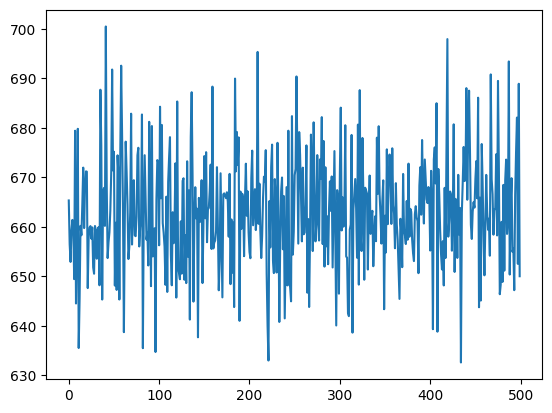

In [9]:
plt.plot(losses['train']['loss'])

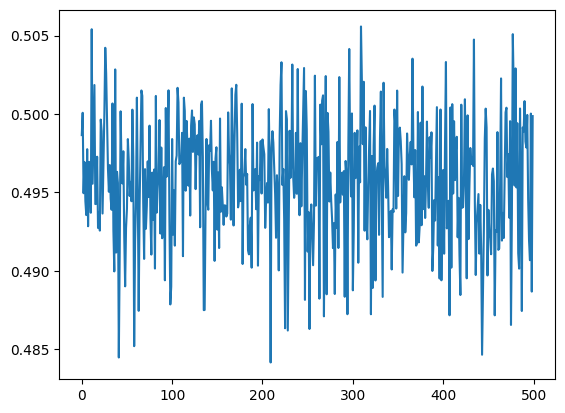

In [10]:
plt.plot(losses['train']['bpr'])

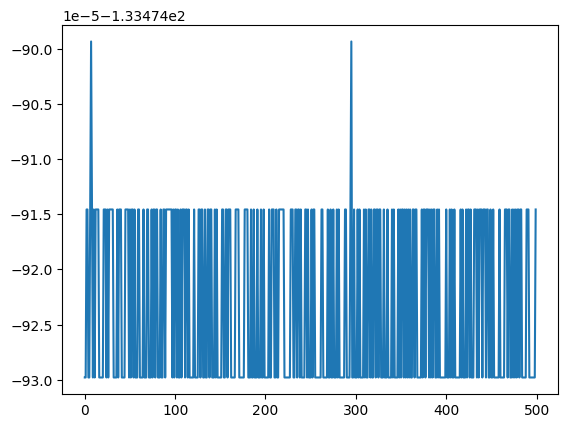

In [11]:
plt.plot(losses['train']['nll'])

In [30]:
# The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

# Run one step of gradient descent by updating
# the value of the variables to minimize the loss.
optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [23]:
# The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]


loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)


In [24]:
overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

In [31]:
overall_gradient

[<tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[-2051.9277  ],
         [   28.857336],
         [  399.91403 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-124.63153], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[-3675.381 ],
         [ 2436.2058],
         [-6397.997 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-75.9808], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[ 1366.0872],
         [-1038.2778],
         [  460.7818]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-125.40878], dtype=float32)>,
 <tf.Tensor: shape=(1, 3, 1), dtype=float32, numpy=
 array([[[ 1.2165532e+00],
         [-1.7127294e+03],
         [-7.4624666e-03]]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-166.89308], dtype=float32)>,
 <tf.Tensor: shape=(4, 12), dtype=float32, numpy=
 array([[ 157.31496 ,  -59.354   ,   22.83

In [10]:
param_gradient_pBS

[<tf.Tensor: shape=(50, 12, 1, 3, 1), dtype=float32, numpy=
 array([[[[[3.0151886e-14],
           [3.0151886e-14],
           [3.0151886e-14]]],
 
 
         [[[3.8934676e-08],
           [3.8934676e-08],
           [3.8934676e-08]]],
 
 
         [[[2.3279292e-18],
           [2.3279292e-18],
           [2.3279292e-18]]],
 
 
         ...,
 
 
         [[[0.0000000e+00],
           [0.0000000e+00],
           [0.0000000e+00]]],
 
 
         [[[0.0000000e+00],
           [0.0000000e+00],
           [0.0000000e+00]]],
 
 
         [[[5.4474437e-01],
           [0.0000000e+00],
           [0.0000000e+00]]]],
 
 
 
        [[[[1.3441555e-22],
           [1.3441555e-22],
           [1.3441555e-22]]],
 
 
         [[[7.2140719e-14],
           [7.2140719e-14],
           [7.2140719e-14]]],
 
 
         [[[1.2004921e-07],
           [1.2004921e-07],
           [1.2004921e-07]]],
 
 
         ...,
 
 
         [[[0.0000000e+00],
           [0.0000000e+00],
           [0.0000000e+00]]],
 
 
 

In [22]:

loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

AttributeError: 'NoneType' object has no attribute 'shape'

In [25]:
def score_farction_trick(jacobian_MBSp, decision_MBS):
    num_param_dims = tf.rank(jacobian_MBSp)-3
    # expand decision to match jacobian
    decision_MBSp = tf.reshape(decision_MBS, decision_MBS.shape + [1]*num_param_dims.numpy())

    scaled_jacobian_MBSp = jacobian_MBSp*decision_MBSp

    # average over sample dims
    param_gradient_BSp = tf.reduce_mean(scaled_jacobian_MBSp, axis=0)

    return param_gradient_BSp

In [7]:
[score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

[<tf.Tensor: shape=(300, 12, 1, 3, 1), dtype=float32, numpy=
 array([[[[[-9.8181177e-17],
           [-9.8181177e-17],
           [-9.8181177e-17]]],
 
 
         [[[ 4.7618383e-14],
           [ 4.7618383e-14],
           [ 4.7618383e-14]]],
 
 
         [[[-5.6410694e-17],
           [-5.6410694e-17],
           [-5.6410694e-17]]],
 
 
         ...,
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]],
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]],
 
 
         [[[ 1.1194237e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]]],
 
 
 
        [[[[-7.8514343e-17],
           [-7.8514343e-17],
           [-7.8514343e-17]]],
 
 
         [[[-3.3463604e-16],
           [-3.3463604e-16],
           [-3.3463604e-16]]],
 
 
         [[[ 3.6076076e-11],
           [ 3.6076076e-11],
           [ 3.6076076e-11]]],
 
 
         ...,
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
     

In [8]:
model.trainable_weights

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.32618928],
         [-0.46606082],
         [-0.24732417]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[1.181708  ],
         [0.84788454],
         [1.1598061 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.46722555],
         [-0.04134607],
         [ 0.956422  ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[-1.0510222 ],
         [ 0.44143808],
         [-1.0136535 ]]], dtype=float32)>,
 <

In [9]:
sample_log_probs_MBS

<tf.Tensor: shape=(50, 300, 12), dtype=float32, numpy=
array([[[ -0.70101863,  -4.1543083 ,  -0.6986769 , ...,  -1.0596602 ,
          -4.743504  ,  -5.4328384 ],
        [ -0.70101863,  -4.0106015 ,  -3.9229648 , ...,  -5.9634576 ,
          -0.6931473 ,  -1.0596601 ],
        [ -0.70101863,  -0.7111152 ,  -0.6986769 , ...,  -0.6931472 ,
          -4.6655827 ,  -0.6931472 ],
        ...,
        [ -0.70101863,  -3.49464   ,  -0.6986769 , ...,  -0.6931472 ,
          -6.9662623 ,  -0.6931472 ],
        [ -0.70101863,  -4.1543083 ,  -0.6986769 , ...,  -1.0596602 ,
          -1.0596601 ,  -4.6279078 ],
        [ -4.4377975 ,  -4.2614584 ,  -4.304028  , ...,  -4.379637  ,
          -4.1970434 ,  -4.5216155 ]],

       [[ -0.70101863,  -4.944219  ,  -3.6131897 , ...,  -3.5844455 ,
          -4.7237096 ,  -4.7751513 ],
        [ -3.5308998 ,  -0.7111152 ,  -5.2043853 , ...,  -4.6070747 ,
          -1.0596601 ,  -0.6931472 ],
        [ -0.70101863,  -3.6862466 ,  -0.6986769 , ...,  -0.693147

In [19]:
losses['train']['loss'][0]

<tf.Tensor: shape=(), dtype=float32, numpy=133.47491>